<a href="https://colab.research.google.com/github/ykitaguchi77/statistics_for_articles/blob/main/Canalicular_excision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import codecs
from scipy import stats
import numpy as np

import numpy as np
import scipy
import matplotlib.pyplot as plt
import statistics as stat

import seaborn as sns; sns.set() # sns.set() ==> グラフの見た目をseabornに合わせる
%matplotlib inline

import math

In [3]:
csv_path = "/content/drive/MyDrive/作成中の論文/涙小管切断/涙小管切除症例1.1.csv"

#Open csv
#with codecs.open(csv_path, "r", "Shift-JIS", "ignore") as file:
with codecs.open(csv_path, "r", "UTF-8", "ignore") as file:
        df = pd.read_csv(file, index_col=None, header=0)
df

,ID,Patient NO,name,OP date,OP date2,Age (yrs),M/F,Background disease,History,Side,...,Observation period (month).1,followup_status,Recurrence,Recurrent period (month),Unnamed: 35,Mibum finding,Mubum score,pre eyedrop,post eyedrop,備考
0,8889238,1,ﾀｶﾀﾆｱﾔｺ,20180920,20181130.0,43,F,"Sjogren, SLE, RA",Punctal occulusion,R,...,36,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,斜視術後
1,8889238,1,ﾀｶﾀﾆｱﾔｺ,20181227,20190815.0,43,F,"Sjogren, SLE, RA",Punctal occulusion,L,...,36,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7971399,2,ｲｽﾞﾐｱｹﾐ,20181227,NaN,74,F,Sjogren,Punctal occulusion,R,...,30,lost,Upper,8.0,NaN,NaN,NaN,NaN,NaN,"Involutional entropion concurrent surgery, cor..."
3,10345769,3,ｵﾀﾞﾁｴｺ,20190131,NaN,82,F,Unknown,Punctal occulusion,R,...,9,lost,None,NaN,NaN,NaN,NaN,D+M+F,SS,NaN
4,10345769,3,ｵﾀﾞﾁｴｺ,20190131,NaN,82,F,Unknown,Punctal occulusion,L,...,9,lost,None,NaN,NaN,NaN,NaN,D+M+F,SS,NaN
5,10546394,4,ｳｽﾞﾊｼﾖｼｺ,20190516,20200513.0,67,F,GVHD,NaN,R,...,17,NaN,Upper,5.0,NaN,黄色分泌,NaN,M,SS+TvO+Eso,Cytomegaro retinitis → PPVtriple
6,10546394,4,ｳｽﾞﾊｼﾖｼｺ,20190516,NaN,67,F,GVHD,NaN,L,...,29,NaN,None,NaN,NaN,黄色分泌,NaN,M,SS+TvO,NaN
7,10696292,5,ﾏﾂｲｱｷﾖ,20190604,NaN,79,F,Sjogren,Punctal occulusion,R,...,19,NaN,None,NaN,NaN,NaN,NaN,D,M,NaN
8,10749858,6,ﾊﾏﾀﾞﾋｻｺ,20190611,NaN,79,F,Sjogren,NaN,R,...,31,NaN,None,NaN,NaN,NaN,NaN,M+D+SS,D+SS,NaN
9,10749858,6,ﾊﾏﾀﾞﾋｻｺ,20190611,NaN,79,F,Sjogren,Punctal occulusion,L,...,27,NaN,None,NaN,NaN,NaN,NaN,M+D+SS,D+SS,NaN


#**フォロー期間12ヶ月以上を抜き出し**

In [ ]:
df_long = df[df['Observation period (month)'] >= 12]
len(df_long)
#df_long.columns
pd.set_option('display.max_columns', 100)

df_long = df_long.reset_index()
df_long


In [58]:
#上下涙点にNoneが含まれている（＝片方の涙点のみ閉鎖）ものとそうでないもの（＝上下涙点を閉鎖）に分類
df_single= df_long.query("Punctum_upper =='None' or Punctum_lower =='None' ")
df_single

df_double = df_long.query("Punctum_upper !='None' and Punctum_lower !='None' ")
df_double

A = np.array(df_single["TM_pre_mm"])
B = np.array(df_double["TM_pre_mm"])
C = np.array(df_single["TM_3M_mm"])
D = np.array(df_double["TM_3M_mm"])
E = np.array(df_single["Fluo_D_pre"])
F = np.array(df_double["Fluo_D_pre"])
G = np.array(df_single["Fluo_D_post"])
H = np.array(df_double["Fluo_D_post"])


#Welch' t-test (不等分散のt検定)
print(stats.ttest_ind(A, B, equal_var=False))
print(stats.ttest_ind(C, D, equal_var=False))
print(stats.ttest_ind(E, F, equal_var=False))
print(stats.ttest_ind(G, H, equal_var=False))


print()
print(df_single["TM_pre_mm"].describe())
print(df_double["TM_pre_mm"].describe())
print()
print(df_single["TM_3M_mm"].describe())
print(df_double["TM_3M_mm"].describe())
print()
print()
print(df_single["Fluo_D_pre"].describe())
print(df_double["Fluo_D_pre"].describe())
print()
print(df_single["Fluo_D_post"].describe())
print(df_double["Fluo_D_post"].describe())


Ttest_indResult(statistic=0.014502457892551127, pvalue=0.9887948622721028)
Ttest_indResult(statistic=-2.23186926795559, pvalue=0.04354099145166274)
Ttest_indResult(statistic=4.472135954999578, pvalue=0.0002945641553666021)
Ttest_indResult(statistic=1.6694662362533008, pvalue=0.11317171074544992)

count    5.000000
mean     0.141982
std      0.035820
min      0.087805
25%      0.126316
50%      0.157895
75%      0.157895
max      0.180000
Name: TM_pre_mm, dtype: float64
count    19.000000
mean      0.141705
std       0.045265
min       0.063158
25%       0.121143
50%       0.134831
75%       0.166967
max       0.240000
Name: TM_pre_mm, dtype: float64

count    5.000000
mean     0.209420
std      0.084951
min      0.126316
25%      0.129730
50%      0.221053
75%      0.240000
max      0.330000
Name: TM_3M_mm, dtype: float64
count    19.000000
mean      0.329771
std       0.166806
min       0.123077
25%       0.236890
50%       0.308483
75%       0.363333
max       0.789474
Name: TM_3M_mm

In [8]:
from sklearn.preprocessing import OneHotEncoder

#解析のため文字列を数値に変える
#症例数が少なければ、csvの列を作り直した方が早い

#男性をゼロ、女性を1に
df_long_1 = df_long.replace({"M/F": {"M": 0, "F": 1}})

df_long_1["Sjogren"] = 0
df_long_1["GVHD"] = 0

#pd.get_dummiesを用いてone-hot encodingを行う
df_long_1 = pd.get_dummies(df_long, columns=["M/F"])
df_long_2 = pd.get_dummies(df_long, columns=["Background disease"])
df_long_2

#Scikit learnからone hot encoderを用いる手法
encoder = OneHotEncoder(sparse=False)

arr = encoder.fit_transform(df_long["M/F"].values.reshape(-1, 1))
df_MF = pd.DataFrame(arr)
df_MF.columns = encoder.get_feature_names_out(["gender"])
df_MF

arr = encoder.fit_transform(df_long["Background disease"].values.reshape(-1, 1))
df_BD = pd.DataFrame(arr)
df_BD.columns = encoder.get_feature_names_out(["Background"])
df_BD

,Background_BSK,Background_GVHD,Background_Post RT,Background_RA+ドライアイ、角膜感染,Background_Sjogren,"Background_Sjogren, SLE, RA",Background_Sjogren未検,Background_強皮症
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
df_long.columns

Index(['index', 'ID', 'Patient NO', 'name', 'OP date', 'OP date2', 'Age (yrs)',
       'M/F', 'Background disease', 'History', 'Side',
       'Observation period (month)', 'Punctum_upper', 'Punctum_lower',
       'Pre Schirmer I', 'FBUT _pre', 'FBUT_post', 'Fluo_A_pre', 'Fluo_D_pre',
       'Fluo_A_post', 'Fluo_D_post', 'Filamentosa_pre', 'Filamentosa_post',
       'TM_pre_px', 'TM_pre_corneaPX', 'TM_pre_mm', 'TM_3M_px',
       'TM_3M_corneaPX', 'TM_3M_mm', 'TM_12M_px', 'TM_12M_corneaPX',
       'TM_12M_mm', 'Observation period (month).1', 'followup_status',
       'Recurrence', 'Recurrent period (month)', 'Unnamed: 35',
       'Mibum finding', 'Mubum score', 'pre eyedrop', 'post eyedrop', '備考'],
      dtype='object')

In [10]:
print(df_long.describe()["TM_pre_mm"])
print("")
print(df_long.describe()["TM_3M_mm"])
print("")
print(df_long.describe()["TM_12M_mm"])
print("")

count    24.000000
mean      0.141763
std       0.042739
min       0.063158
25%       0.123308
50%       0.134831
75%       0.162431
max       0.240000
Name: TM_pre_mm, dtype: float64

count    24.000000
mean      0.304698
std       0.159761
min       0.123077
25%       0.211943
50%       0.293426
75%       0.337500
max       0.789474
Name: TM_3M_mm, dtype: float64

count    24.000000
mean      0.252193
std       0.112405
min       0.090000
25%       0.157895
50%       0.214759
75%       0.339560
max       0.428571
Name: TM_12M_mm, dtype: float64



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


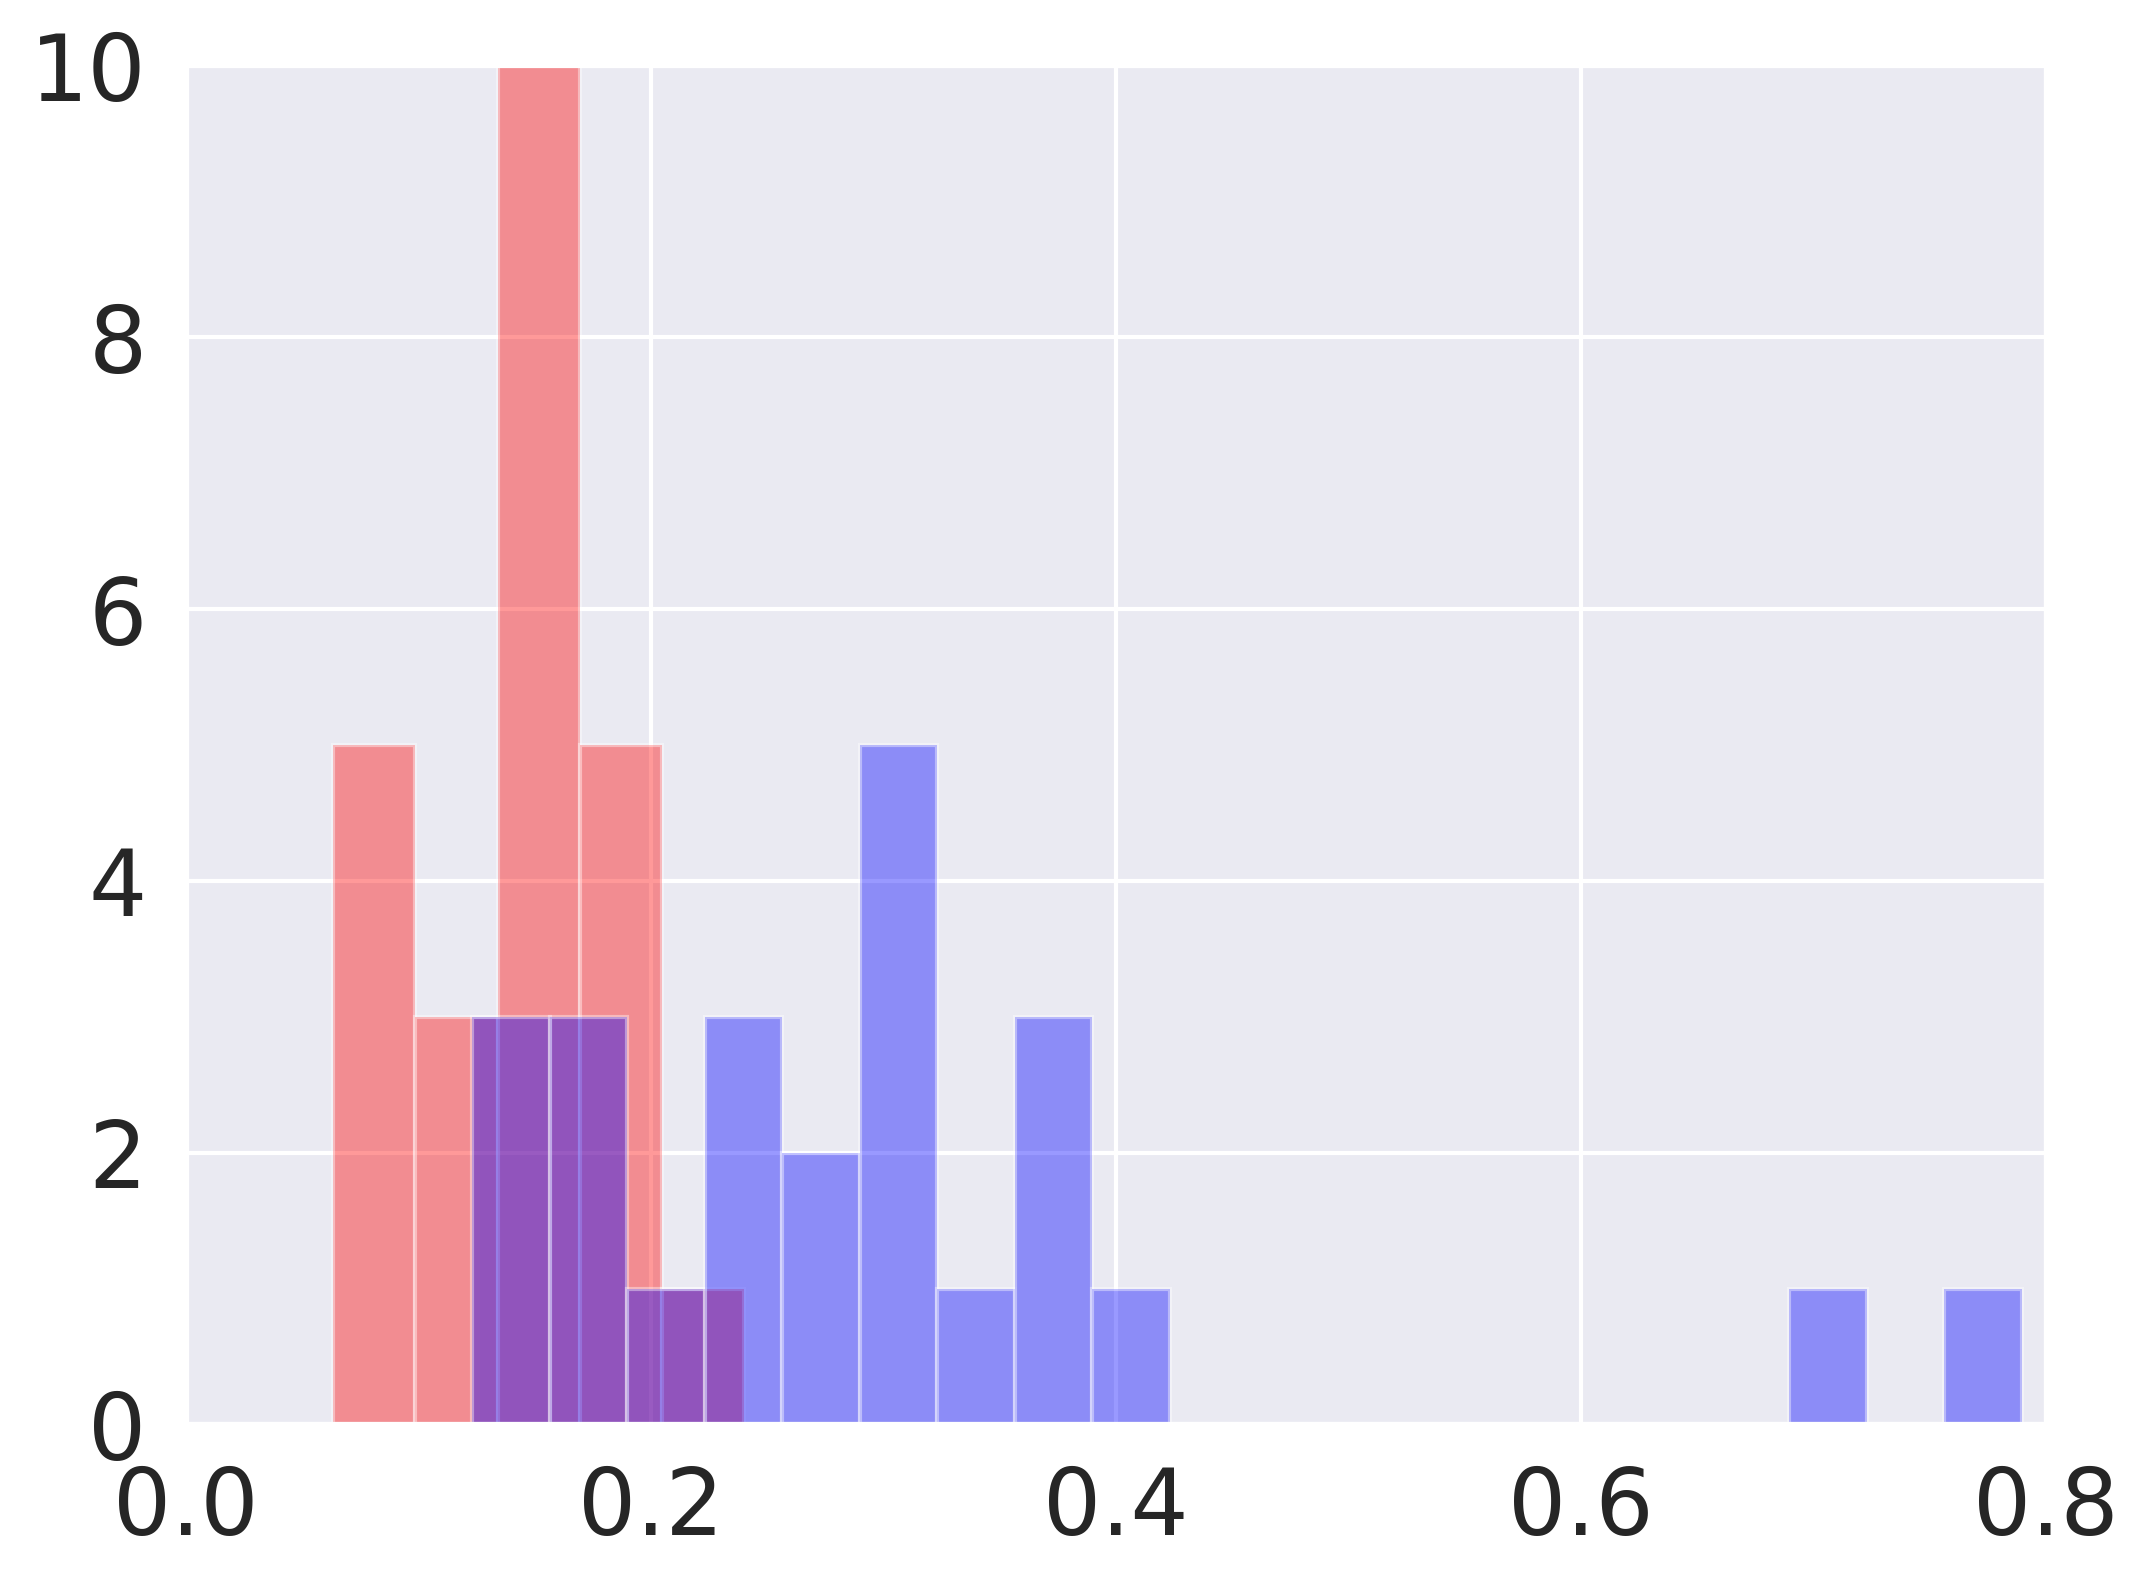

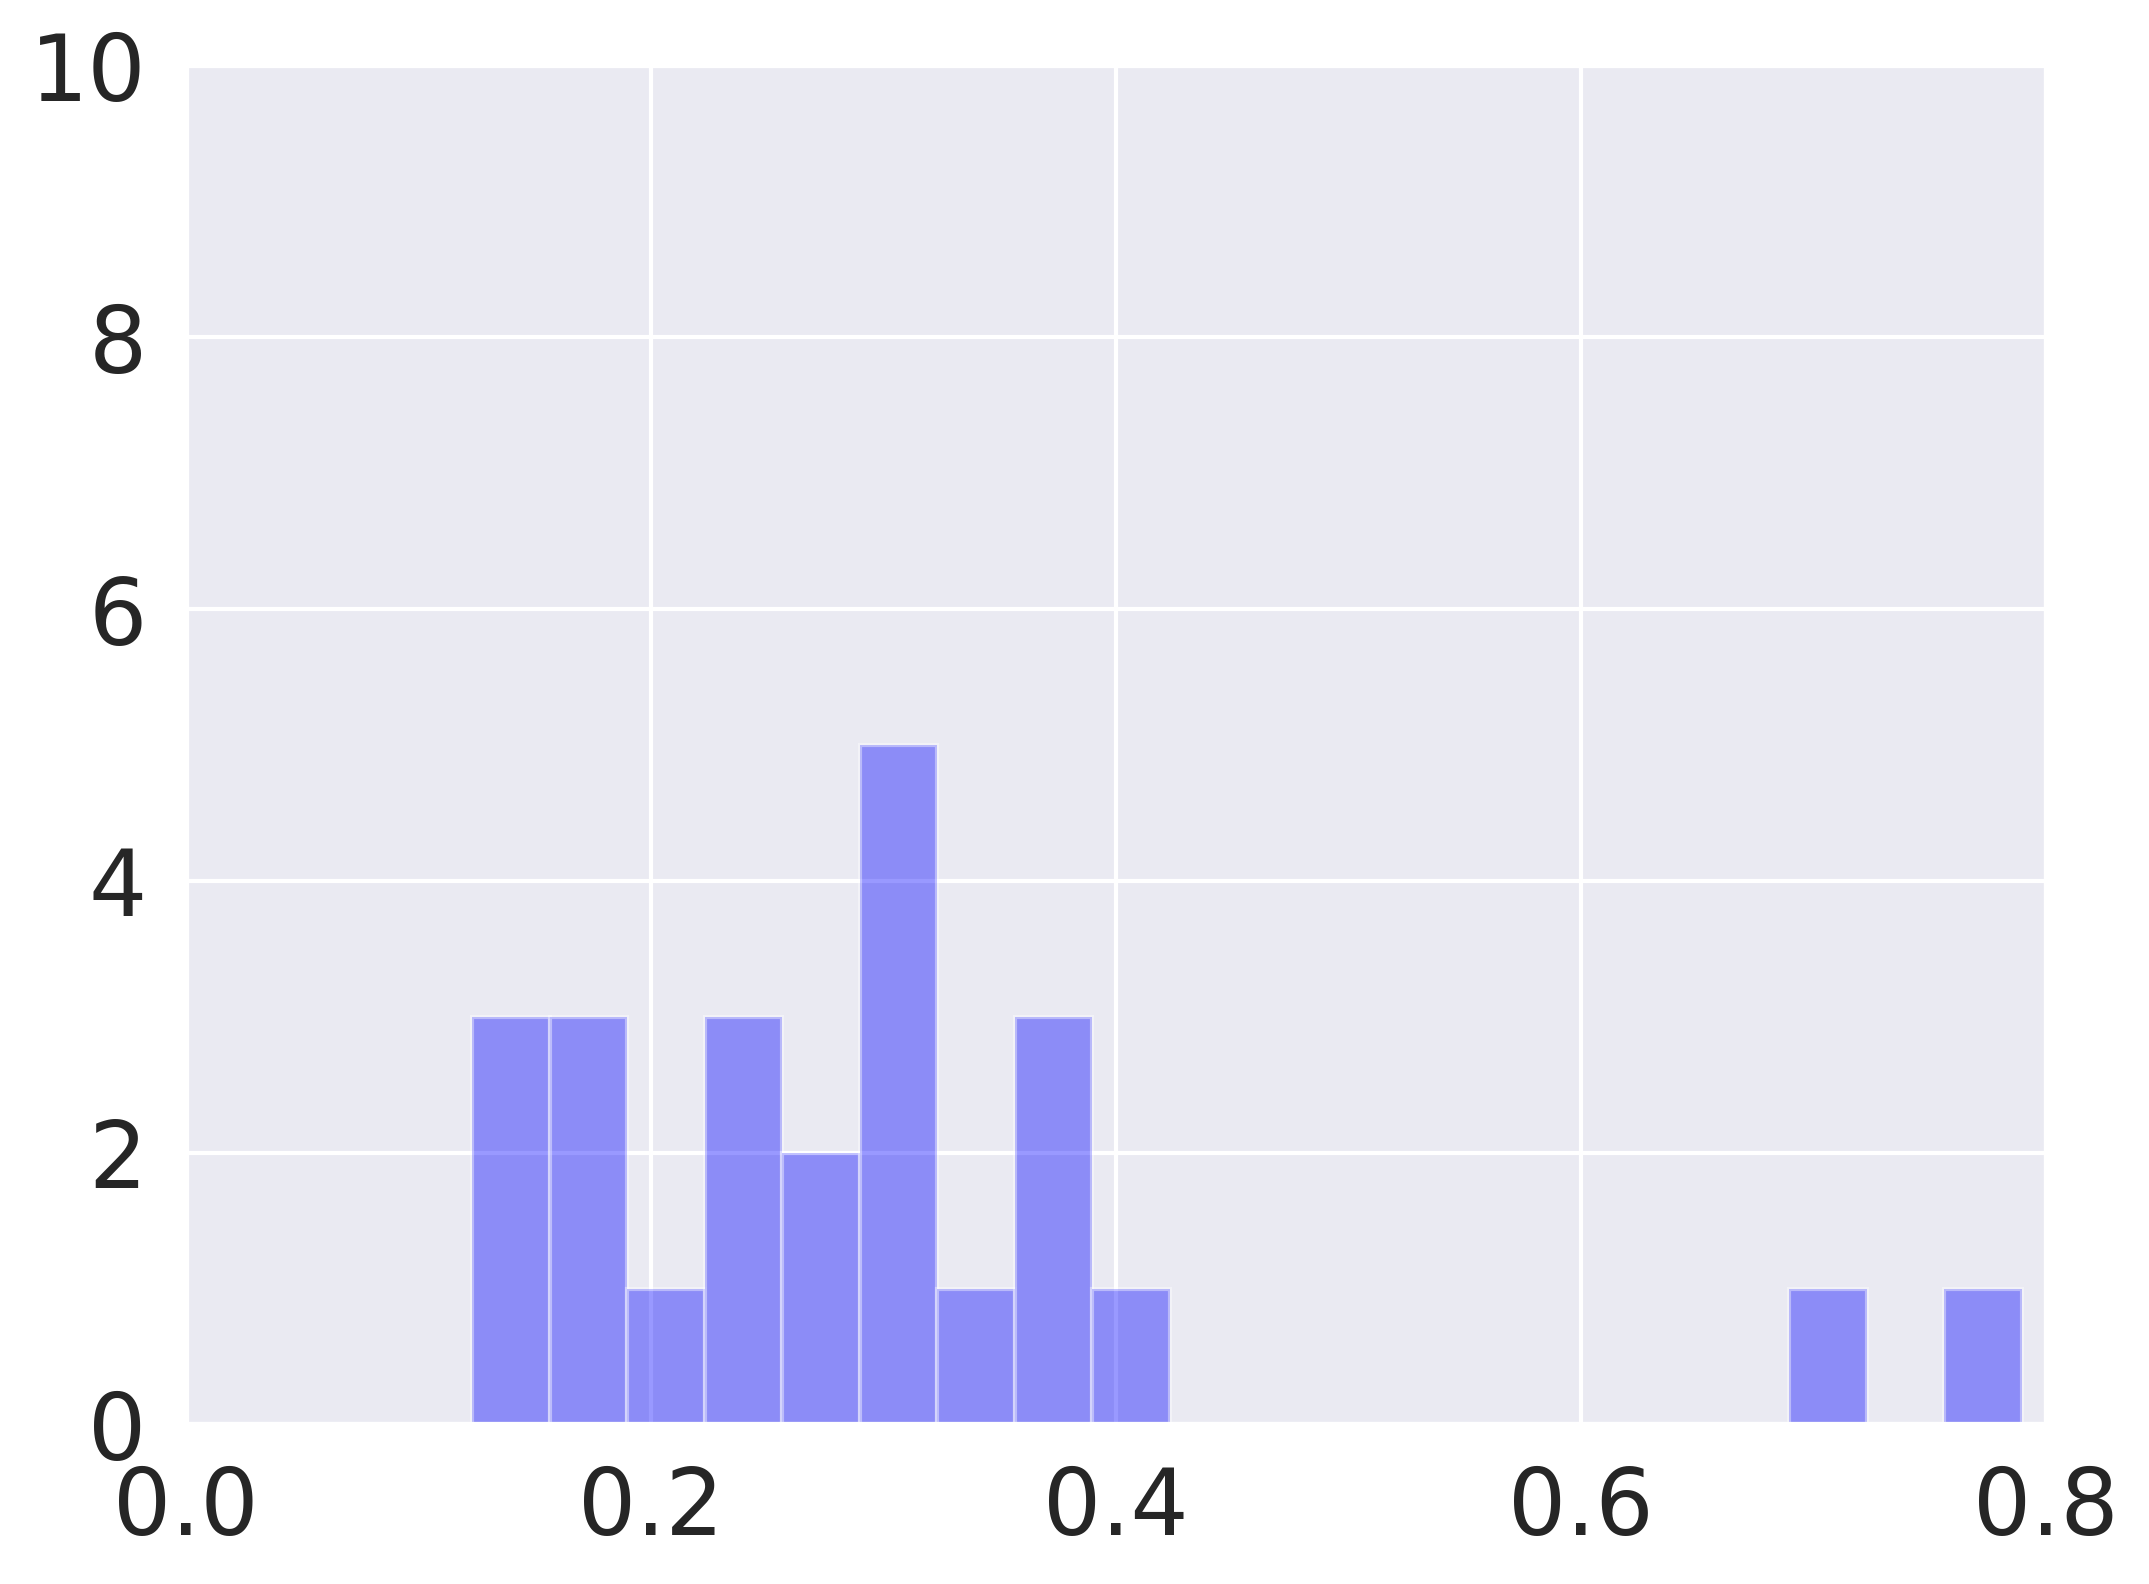

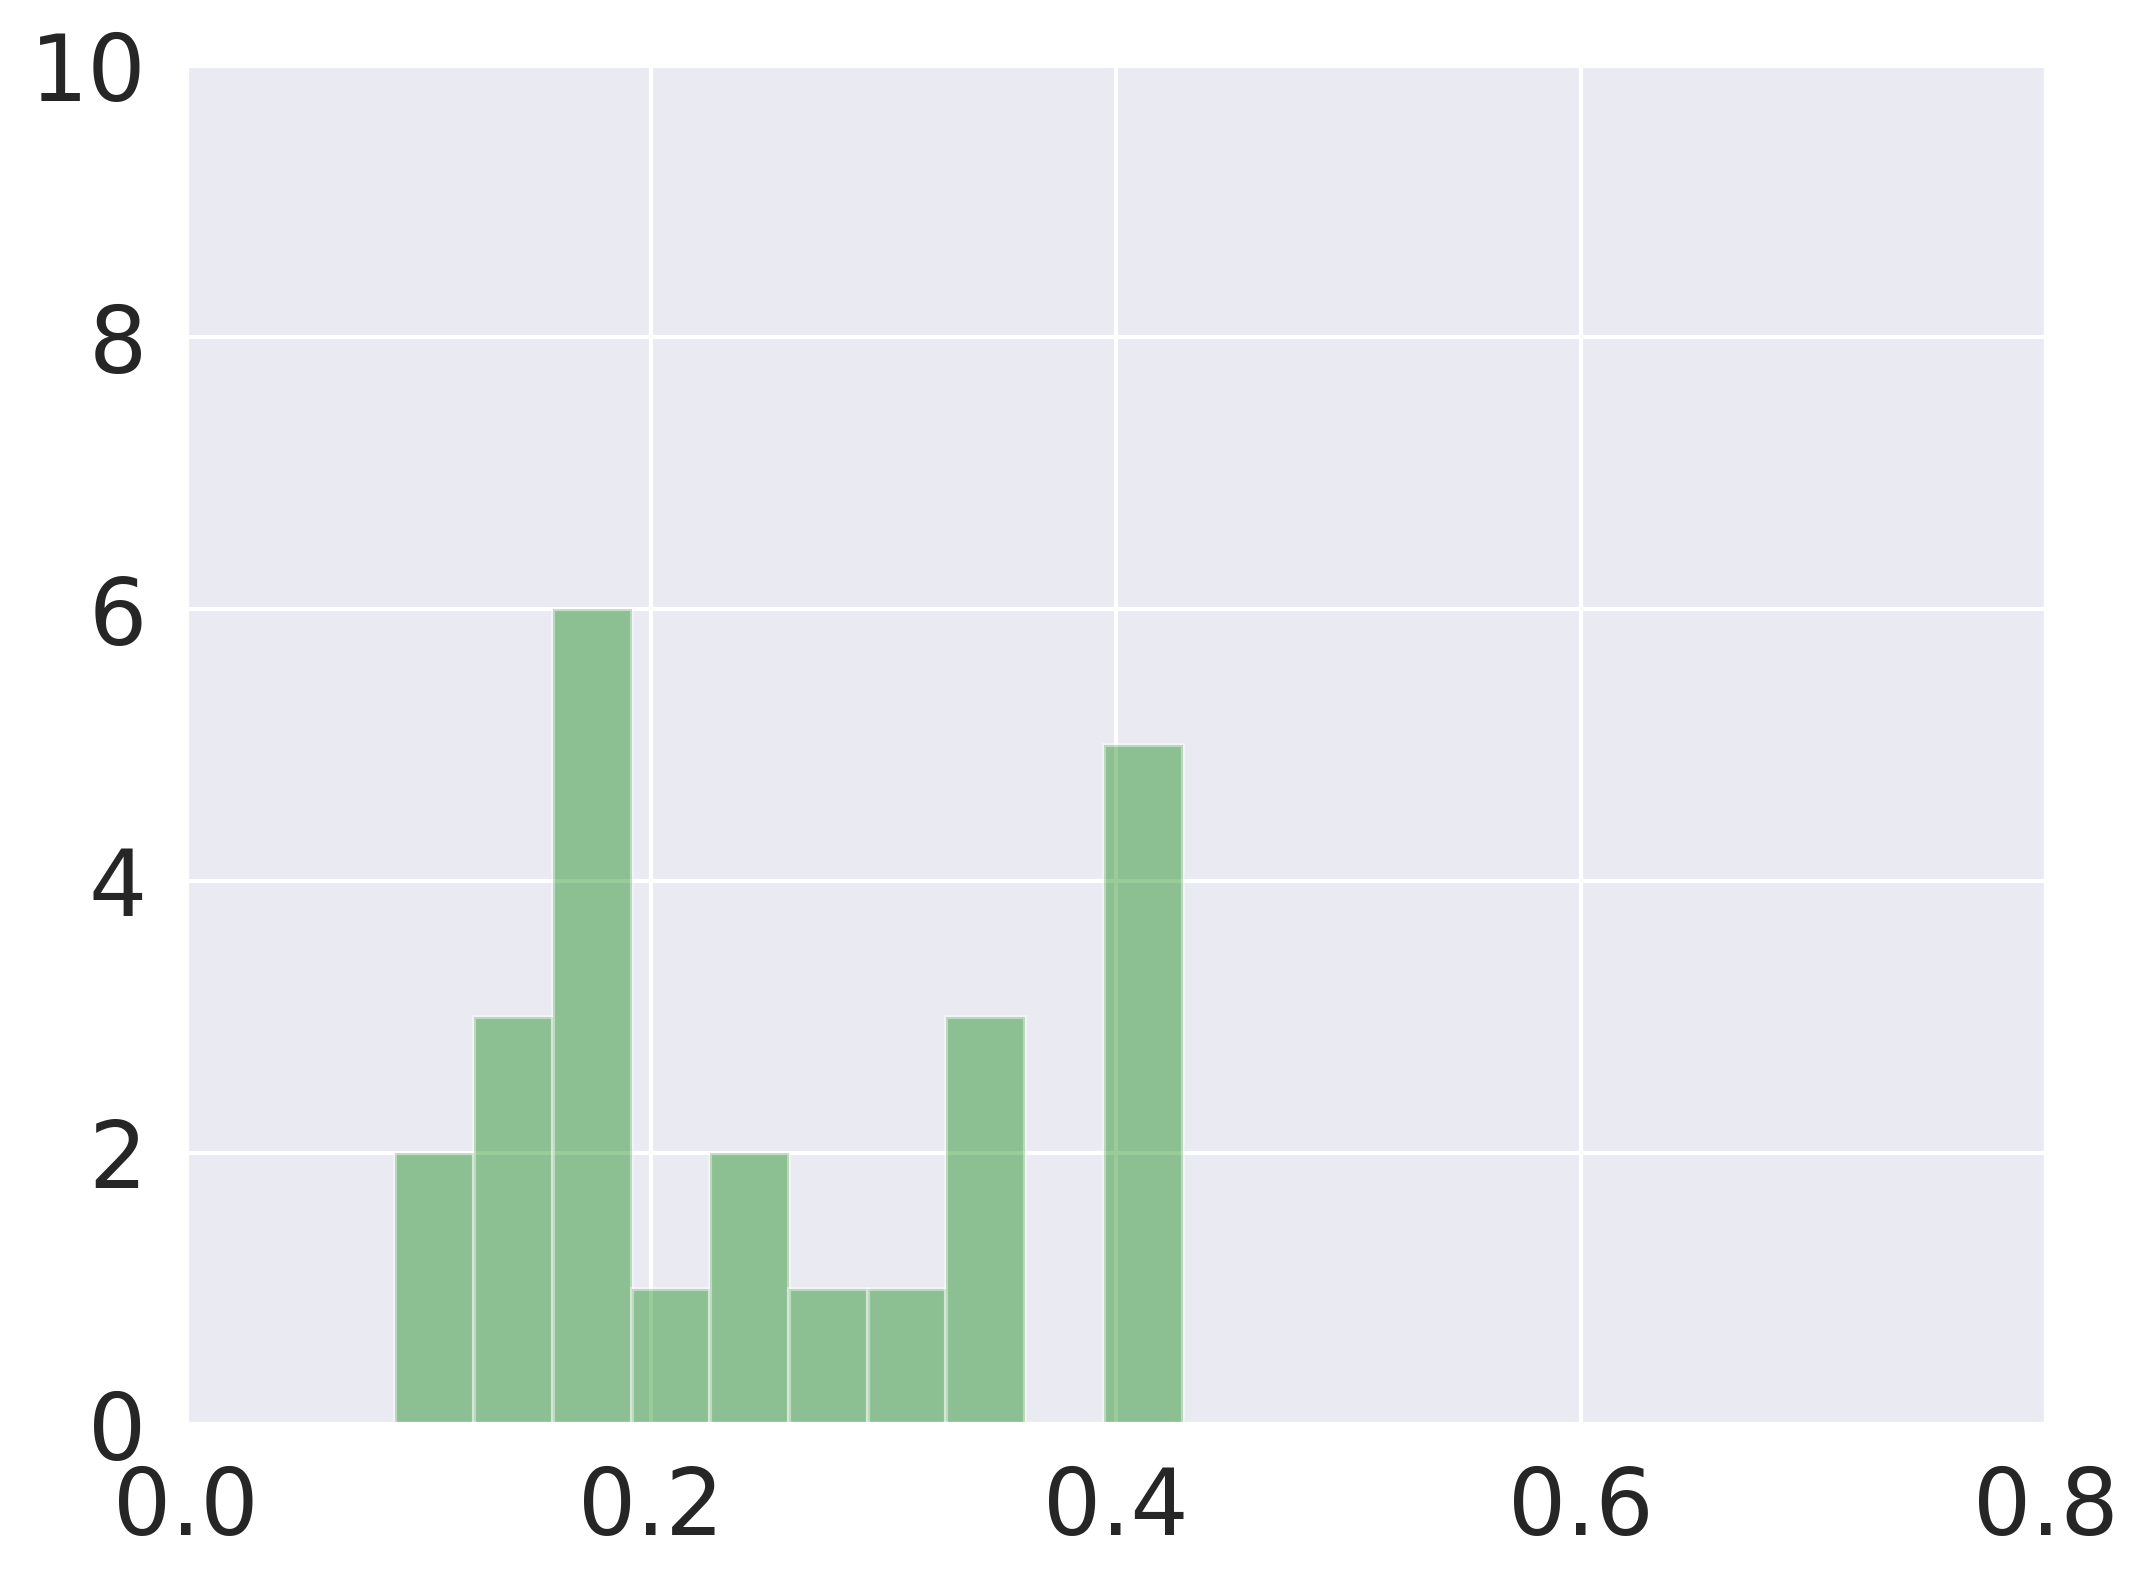

In [ ]:
#TMの変化について検討
A = np.array(df_long["TM_pre_mm"])
B = np.array(df_long["TM_3M_mm"])
C = np.array(df_long["TM_12M_mm"])


"""
# 分散を比べるヒストグラム
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(A, bins=10, density = True, color='red', alpha = 0.7) #Aヒストグラム
ax.hist(B, bins=10, density = True, color='blue', alpha = 0.7) #Bヒストグラム
ax.set_title('Red: pre   Brue: post 3M') #図のタイトル
ax.set_xlabel('mm') #x軸タイトル
ax.set_ylabel('number') #Y軸タイトル
fig.show()
"""

fig, ax = plt.subplots(figsize=(8,6), dpi=300)
sns.distplot(
    A, bins=5, color="red", label="pre", kde=False
)
sns.distplot(
    B, bins=20, color="blue", label="post 3M", kde=False
)
sns.set(font_scale = 2)
plt.xlim(0, 0.8)
plt.ylim(0, 10)
plt.show()

fig, ax = plt.subplots(figsize=(8,6), dpi=300)
sns.distplot(
    B, bins=20, color="blue", label="post 3M", kde=False
)
sns.set(font_scale = 2)
plt.xlim(0, 0.8)
plt.ylim(0, 10)
plt.show()

fig, ax = plt.subplots(figsize=(8,6), dpi=300)
sns.distplot(
    C, bins=10, color="green", label="post 3M", kde=False
)
sns.set(font_scale = 2)
plt.xlim(0, 0.8)
plt.ylim(0, 10)
plt.show()



In [20]:
#TMの変化について検討
A = np.array(df_long["TM_pre_mm"])
B = np.array(df_long["TM_3M_mm"])
C = np.array(df_long["TM_12M_mm"])

#等分散検定（どちらかで<0.05ならt検定は使わない方が無難）
print(scipy.stats.bartlett(A,B))
print(scipy.stats.levene(A,B))

#等分散の確認 その2
A_var = np.var(A, ddof=1)  # Aの不偏分散
B_var = np.var(B, ddof=1)  # Bの不偏分散
A_df = len(A) - 1  # Aの自由度
B_df = len(B) - 1  # Bの自由度
f = A_var / B_var  # F比の値
one_sided_pval1 = stats.f.cdf(f, A_df, B_df)  # 片側検定のp値 1
one_sided_pval2 = stats.f.sf(f, A_df, B_df)   # 片側検定のp値 2
two_sided_pval = min(one_sided_pval1, one_sided_pval2) * 2  # 両側検定のp値
print('F:       ', round(f, 3))
print('p-value: ', round(two_sided_pval, 3)) #p<0.05なら分散が等しくないと言える

#等分散の確認 その3
varA = stats.tvar(A)
varB = stats.tvar(B)
dfn = len(B) -1
dfd = len(A) -1
f = varB/varA #分子に大きい方を置く
print("f_value: ", f)
p = stats.f.cdf(f, dfn=dfn, dfd=dfd)
print("p-value: ", p) #p>0.05なら分散が等しくないと言える

#正規性の検定（分散が等しい場合に使える）
#p<0.05の場合だと正規分布ではないのでt検定は使えない
print(stats.shapiro(A))
print(stats.shapiro(B))



#等分散かつ正規分布ならstudent-t
print(stats.ttest_rel(A, B))

#Wilcoxon
print(stats.wilcoxon(A, B,  correction=True))
print(stats.wilcoxon(B, C,  correction=True))

BartlettResult(statistic=31.26883121664102, pvalue=2.2465768882309444e-08)
LeveneResult(statistic=7.6057171424981, pvalue=0.008318694879385682)
F:        0.072
p-value:  0.0
f_value:  13.972889698874198
p-value:  0.9999999891745881
(0.9763689041137695, 0.8207359313964844)
(0.800627589225769, 0.0003016219416167587)
Ttest_relResult(statistic=-5.105353817712703, pvalue=3.593333661080229e-05)
WilcoxonResult(statistic=5.0, pvalue=3.633553465191629e-05)
WilcoxonResult(statistic=88.0, pvalue=0.2171954808721165)


In [21]:
df_long.value_counts("M/F")

M/F
F    17
M     7
dtype: int64

In [ ]:
df_long.describe()["Age (yrs)"]

count    24.000000
mean     58.333333
std      15.159060
min      37.000000
25%      48.000000
50%      53.000000
75%      73.250000
max      86.000000
Name: Age (yrs), dtype: float64

In [ ]:
df_long.value_counts("Side")

Side
R    13
L    11
dtype: int64

In [ ]:
df_long.value_counts("History")

History
Punctal occulusion    5
dtype: int64

In [ ]:
df_long.describe()["Pre Schirmer I"]

count    23.000000
mean      3.130435
std       2.379923
min       0.000000
25%       1.500000
50%       2.000000
75%       3.500000
max       8.000000
Name: Pre Schirmer I, dtype: float64

In [ ]:
df_long.value_counts("History")

History
Punctal occulusion    5
dtype: int64

In [ ]:
print(df_long.describe()["Fluo_D_pre"])
print(df_long.value_counts("Fluo_D_pre"))

count    24.000000
mean      2.583333
std       0.503610
min       2.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       3.000000
Name: Fluo_D_pre, dtype: float64
Fluo_D_pre
3.0    14
2.0    10
dtype: int64


In [ ]:
print(df_long.describe()["Fluo_D_pre"])
print(df_long.value_counts("Fluo_D_pre"))

In [ ]:
print(df_long.describe()["Fluo_D_post"])
print(df_long.value_counts("Fluo_D_post"))

count    24.000000
mean      1.375000
std       1.013496
min       0.000000
25%       0.750000
50%       1.500000
75%       2.000000
max       3.000000
Name: Fluo_D_post, dtype: float64
Fluo_D_post
2.0    9
0.0    6
1.0    6
3.0    3
dtype: int64


In [ ]:
print(df_long.describe()["Filamentosa_pre"])
print(df_long.value_counts("Filamentosa_pre"))

count    24.000000
mean      0.208333
std       0.414851
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: Filamentosa_pre, dtype: float64
Filamentosa_pre
0.0    19
1.0     5
dtype: int64


In [ ]:
print(df_long.describe()["Filamentosa_post"])
print(df_long.value_counts("Filamentosa_post"))

count    24.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: Filamentosa_post, dtype: float64
Filamentosa_post
0.0    24
dtype: int64


In [ ]:
print(df_long.describe()["Pre Schirmer I"])
print(df_long.value_counts("Pre Schirmer I"))


count    23.000000
mean      3.130435
std       2.379923
min       0.000000
25%       1.500000
50%       2.000000
75%       3.500000
max       8.000000
Name: Pre Schirmer I, dtype: float64
Pre Schirmer I
2.0    6
1.0    5
3.0    5
7.0    4
0.0    1
4.0    1
8.0    1
dtype: int64


In [ ]:
print(df_long.describe()["Recurrent period (month)"])


count    4.000000
mean     4.250000
std      2.986079
min      1.000000
25%      2.500000
50%      4.000000
75%      5.750000
max      8.000000
Name: Recurrent period (month), dtype: float64


In [ ]:
print(df_long.columns)

Index(['ID', 'Patient NO', 'name', 'OP date', 'OP date2', 'Age (yrs)', 'M/F',
       'Background disease', 'History', 'Side', 'Observation period (month)',
       'Punctum_upper', 'Punctum_lower', 'Pre Schirmer I', 'TMR_pre',
       'TMR_post', 'FBUT_Pre', 'FBUT_post', 'Fluo_A_pre', 'Fluo_D_pre',
       'Fluo_A_post', 'Fluo_A_post.1', 'Filamentosa_pre', 'Filamentosa_post',
       'Post tear meniscus', 'Recurrence', 'Recurrent period (month)',
       'Unnamed: 27', 'Mibum finding', 'Mubum score', 'pre eyedrop',
       'post eyedrop', '備'],
      dtype='object')


In [ ]:
#Fluoの変化は有意
stats.wilcoxon(df_long['Fluo_D_pre'], df_long['Fluo_D_post'])

WilcoxonResult(statistic=0.0, pvalue=0.00021982609891843375)

In [ ]:
print(df_long.columns)

Index(['ID', 'Patient NO', 'name', 'OP date', 'OP date2', 'Age (yrs)', 'M/F',
       'Background disease', 'History', 'Side', 'Observation period (month)',
       'Punctum_upper', 'Punctum_lower', 'Pre Schirmer I', 'TMR_pre',
       'TMR_post', 'FBUT_Pre', 'FBUT_post', 'Fluo_A_pre', 'Fluo_D_pre',
       'Fluo_A_post', 'Fluo_D_post', 'Filamentosa_pre', 'Filamentosa_post',
       'Post tear meniscus', 'Recurrence', 'Recurrent period (month)',
       'Unnamed: 27', 'Mibum finding', 'Mubum score', 'pre eyedrop',
       'post eyedrop', '備', 'Backgroud_Sjogren', 'Background_GVHD',
       'Gender_F'],
      dtype='object')


In [ ]:
#欠損値の確認
df_long.isnull().sum()

ID                             0
Patient NO                     0
name                           0
OP date                        0
OP date2                      21
Age (yrs)                      0
M/F                            0
Background disease             0
History                       19
Side                           0
Observation period (month)     0
Punctum_upper                  0
Punctum_lower                  0
Pre Schirmer I                 1
TMR_pre                       24
TMR_post                      24
FBUT_Pre                      17
FBUT_post                     20
Fluo_A_pre                     0
Fluo_D_pre                     0
Fluo_A_post                    0
Fluo_D_post                    0
Filamentosa_pre                0
Filamentosa_post               0
Post tear meniscus            22
Recurrence                     0
Recurrent period (month)      20
Unnamed: 27                   24
Mibum finding                 22
Mubum score                   24
pre eyedro

In [ ]:
#欠損値を中央値で埋める
df_long['Pre Schirmer I'] = df_long['Pre Schirmer I'].fillna(df_long['Pre Schirmer I'].median())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
from sklearn import linear_model

#X = df_long.loc[:, ["Fluo_D_pre", "Filamentosa_pre", "Pre Schirmer I", "Age (yrs)", "Gender_F", "Backgroud_Sjogren", "Background_GVHD"]].values
X = df_long.loc[:, ["Fluo_D_pre", "Filamentosa_pre", "Pre Schirmer I"]].values

Y = df_long["Fluo_D_post"].values

model = linear_model.LinearRegression()
model.fit(X,Y)
model.coef_

# データフレームに変換し、カラム名とインデックス名を指定
#df_coefficient = pd.DataFrame(model.coef_, columns=["Fluo_D_post"], index=["Fluo_D_pre", "Filamentosa_pre", "Pre Schirmer I", "Age (yrs)", "Gender_F", "Backgroud_Sjogren", "Background_GVHD"])
df_coefficient = pd.DataFrame(model.coef_, columns=["Fluo_D_post"], index=["Fluo_D_pre", "Filamentosa_pre", "Pre Schirmer I"])
df_coefficient

,Fluo_D_post
Fluo_D_pre,0.715648
Filamentosa_pre,-0.712874
Pre Schirmer I,-0.024621


In [ ]:
import statsmodels.api as sm

model = sm.OLS(Y, sm.add_constant(X))
results = model.fit()
print(results.summary())
# --> 術後SPKの重症度と有意に相関する項目なし


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     1.624
Date:                Mon, 28 Feb 2022   Prob (F-statistic):              0.215
Time:                        08:05:14   Log-Likelihood:                -31.249
No. Observations:                  24   AIC:                             70.50
Df Residuals:                      20   BIC:                             75.21
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2493      1.135     -0.220      0.8

In [ ]:
df_long.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))


,ID,Patient NO,OP date,OP date2,Age (yrs),Observation period (month),Pre Schirmer I,FBUT _pre,FBUT_post,Fluo_A_pre,Fluo_D_pre,Fluo_A_post,Fluo_D_post,Filamentosa_pre,Filamentosa_post,TM_pre_px,TM_pre_corneaPX,TM_pre_mm,TM_3M_px,TM_3M_corneaPX,TM_3M_mm,TM_12M_px,TM_12M_corneaPX,TM_12M_mm,Observation period (month).1,Recurrent period (month),Unnamed: 35,Mubum score
count,24,24,24,3,24,24,23,7,4,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,4,0,0
mean,9.84823e+06,12.375,2.0196e+07,2.01908e+07,58.3333,22.5,3.13043,1.57143,4.5,2.16667,2.58333,1.41667,1.375,0.208333,0,4.41667,378.417,0.141763,9.45833,376.875,0.304698,7.70833,388.333,0.252193,22.5,4.25,nan,nan
std,2.15076e+06,8.3396,9939.24,9691.5,15.1591,8.1827,2.37992,0.534522,2.88675,0.701964,0.50361,1.05981,1.0135,0.414851,0,1.66594,41.1835,0.0427392,5.38903,42.0541,0.159761,3.15511,16.3486,0.112405,8.1827,2.98608,nan,nan
min,4.54445e+06,1,2.01809e+07,2.01811e+07,37,12,0,1,2,1,2,0,0,0,0,2,259,0.0631579,4,250,0.123077,3,360,0.09,12,1,nan,nan
25%,8.88924e+06,5.75,2.01906e+07,2.0186e+07,48,14.75,1.5,1,2,2,2,0.75,0.75,0,0,3,373.75,0.123308,6,377.5,0.211943,5,380,0.157895,14.75,2.5,nan,nan
50%,1.05975e+07,10,2.01909e+07,2.01908e+07,53,24,2,2,4.5,2,3,1.5,1.5,0,0,4,380,0.134831,8,384.5,0.293426,7.5,389.5,0.214759,24,4,nan,nan
75%,1.13091e+07,20.25,2.02033e+07,2.01957e+07,73.25,28.25,3.5,2,7,3,3,2,2,0,0,5.25,400,0.162431,11,400,0.3375,10.25,400,0.33956,28.25,5.75,nan,nan
max,1.19715e+07,26,2.02104e+07,2.02005e+07,86,36,8,2,7,3,3,3,3,1,0,8,429,0.24,25,420,0.789474,15,420,0.428571,36,8,nan,nan


In [ ]:
# matplotlibを日本語表示に対応させるモジュール
!pip install japanize_matplotlib
import japanize_matplotlib

# pandasのplottingメソッドをインポート
from pandas import plotting

# 散布図行列を表示
df_Z = df_long[["Fluo_D_pre", "Fluo_D_post", "Filamentosa_pre", "Pre Schirmer I", "Age (yrs)", "Gender_F", "Backgroud_Sjogren", "Background_GVHD"]]
plotting.scatter_matrix(df_Z, figsize=(20, 20), alpha=0.8)

In [ ]:
df_Z.corr()
# --> 相関が多少でもありそうなのは、pre-ShirmerとFluo-D-preぐらい

,Fluo_D_pre,Fluo_D_post,Filamentosa_pre,Pre Schirmer I,Age (yrs),Gender_F,Backgroud_Sjogren,Background_GVHD
Fluo_D_pre,1.000000,0.319438,0.017342,0.547498,0.201229,-0.170445,0.268566,-0.218218
Fluo_D_post,0.319438,1.000000,-0.297301,0.077948,-0.059429,-0.034648,-0.431962,0.227710
Filamentosa_pre,0.017342,-0.297301,1.000000,0.205365,0.085268,-0.122267,0.145854,-0.185435
Pre Schirmer I,0.547498,0.077948,0.205365,1.000000,0.120578,-0.617198,0.003043,-0.216127
Age (yrs),0.201229,-0.059429,0.085268,0.120578,1.000000,0.131782,0.261093,-0.371178
Gender_F,-0.170445,-0.034648,-0.122267,-0.617198,0.131782,1.000000,0.406288,-0.260360
Backgroud_Sjogren,0.268566,-0.431962,0.145854,0.003043,0.261093,0.406288,1.000000,-0.712525
Background_GVHD,-0.218218,0.227710,-0.185435,-0.216127,-0.371178,-0.260360,-0.712525,1.000000


Pre_Fluo D2:
       Fluo_D_pre  Pre Schirmer I
count        10.0       10.000000
mean          2.0        1.600000
std           0.0        0.966092
min           2.0        0.000000
25%           2.0        1.000000
50%           2.0        1.500000
75%           2.0        2.000000
max           2.0        3.000000
Pre_Fluo D3:
       Fluo_D_pre  Pre Schirmer I
count        14.0       14.000000
mean          3.0        4.142857
std           0.0        2.476261
min           3.0        1.000000
25%           3.0        2.000000
50%           3.0        3.000000
75%           3.0        7.000000
max           3.0        8.000000
Pre_Fluo D2:
0     1.0
1     3.0
5     1.0
6     1.0
7     2.0
10    2.0
22    0.0
23    1.0
35    3.0
36    2.0
Name: Pre Schirmer I, dtype: float64
Pre_Fluo D3:
2     2.0
8     3.0
9     2.0
11    4.0
12    2.0
13    1.0
15    7.0
20    8.0
21    2.0
25    7.0
26    3.0
28    7.0
29    7.0
30    3.0
Name: Pre Schirmer I, dtype: float64
0.10592225143757877


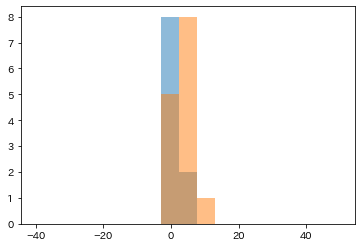

Ttest_indResult(statistic=-3.4885285422154535, pvalue=0.0026309609708969257)

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt

df_Kruskal = df_long[["Fluo_D_pre", "Pre Schirmer I"]]
B = df_Kruskal.query("Fluo_D_pre == 2")
C = df_Kruskal.query("Fluo_D_pre == 3")
print("Pre_Fluo D2:")
print(B.describe())
print("Pre_Fluo D3:")
print(C.describe())

y = B["Pre Schirmer I"]
z = C["Pre Schirmer I"]

print("Pre_Fluo D2:")
print(y)
print("Pre_Fluo D3:")
print(z)

# visualize
bins = np.linspace(-40,50,18)
plt.hist(y,bins,alpha=0.5)
plt.hist(z,bins,alpha=0.5)

# hypothesis testing
result = stats.mannwhitneyu(x,y)
print(result.pvalue)

plt.show()

#Welchのt検定
stats.ttest_ind(y,z, equal_var = False)


#--> シルマー値が高いほど、術前の角膜上皮障害が強い、となり実情にそぐわない

In [ ]:
from scipy import stats
df_Kruskal = df_long[["Fluo_D_post", "Pre Schirmer I"]]
A = df_Kruskal.query("Fluo_D_post == 1")
B = df_Kruskal.query("Fluo_D_post == 2")
C = df_Kruskal.query("Fluo_D_post == 3")
print("Post_Fluo D1:")
print(A.describe())
print("Post_Fluo D2:")
print(B.describe())
print("Post_Fluo D3:")
print(C.describe())


x = A["Pre Schirmer I"]
y = B["Pre Schirmer I"]
z = C["Pre Schirmer I"]

print("Post_Fluo D1:")
print(x)
print("Post_Fluo D2:")
print(y)
print("Post_Fluo D3:")
print(z)


stats.kruskal(x, y, z)

#--> シルマー値が低いほど、術前の角膜上皮障害が強い

Post_Fluo D1:
       Fluo_D_post  Pre Schirmer I
count          6.0        6.000000
mean           1.0        2.833333
std            0.0        2.136976
min            1.0        1.000000
25%            1.0        2.000000
50%            1.0        2.000000
75%            1.0        2.750000
max            1.0        7.000000
Post_Fluo D2:
       Fluo_D_post  Pre Schirmer I
count          9.0        9.000000
mean           2.0        2.777778
std            0.0        2.905933
min            2.0        0.000000
25%            2.0        1.000000
50%            2.0        1.000000
75%            2.0        4.000000
max            2.0        8.000000
Post_Fluo D3:
       Fluo_D_post  Pre Schirmer I
count          3.0        3.000000
mean           3.0        4.333333
std            0.0        2.309401
min            3.0        3.000000
25%            3.0        3.000000
50%            3.0        3.000000
75%            3.0        5.000000
max            3.0        7.000000
Post_Fluo D1:

KruskalResult(statistic=2.195757250268524, pvalue=0.33357797757692237)

#**患者別**

In [22]:
df_long_pts = df_long.drop_duplicates(subset=['Patient NO'], keep="last")
print("Patient number: ", len(df_long_pts))
df_long_pts


Patient number:  17


,index,ID,Patient NO,name,OP date,OP date2,Age (yrs),M/F,Background disease,History,Side,Observation period (month),Punctum_upper,Punctum_lower,Pre Schirmer I,FBUT _pre,FBUT_post,Fluo_A_pre,Fluo_D_pre,Fluo_A_post,Fluo_D_post,Filamentosa_pre,Filamentosa_post,TM_pre_px,TM_pre_corneaPX,TM_pre_mm,TM_3M_px,TM_3M_corneaPX,TM_3M_mm,TM_12M_px,TM_12M_corneaPX,TM_12M_mm,Observation period (month).1,followup_status,Recurrence,Recurrent period (month),Unnamed: 35,Mibum finding,Mubum score,pre eyedrop,post eyedrop,備考
1,1,8889238,1,ﾀｶﾀﾆｱﾔｺ,20181227,20190815.0,43,F,"Sjogren, SLE, RA",Punctal occulusion,L,36,Second,First,3.0,2.0,7.0,2,2,0,0,0,0,5,386,0.155440,9,360,0.300000,12.0,360.0,0.400000,36,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,7971399,2,ｲｽﾞﾐｱｹﾐ,20181227,NaN,74,F,Sjogren,Punctal occulusion,R,30,First,First,2.0,NaN,NaN,2,3,0,0,0,0,6,409,0.176039,10,389,0.308483,10.0,389.0,0.400000,30,lost,Upper,8.0,NaN,NaN,NaN,NaN,NaN,"Involutional entropion concurrent surgery, cor..."
4,6,10546394,4,ｳｽﾞﾊｼﾖｼｺ,20190516,NaN,67,F,GVHD,NaN,L,29,First,First,1.0,2.0,NaN,2,2,1,2,0,0,2,380,0.063158,9,380,0.284211,5.0,380.0,0.157895,29,NaN,None,NaN,NaN,黄色分泌,NaN,M,SS+TvO,NaN
5,7,10696292,5,ﾏﾂｲｱｷﾖ,20190604,NaN,79,F,Sjogren,Punctal occulusion,R,19,First,First,2.0,1.0,NaN,3,2,0,0,0,0,2,336,0.071429,6,390,0.184615,6.0,390.0,0.184615,19,NaN,None,NaN,NaN,NaN,NaN,D,M,NaN
7,9,10749858,6,ﾊﾏﾀﾞﾋｻｺ,20190611,NaN,79,F,Sjogren,Punctal occulusion,L,27,First,First,2.0,1.0,2.0,2,3,2,1,0,0,4,259,0.185328,6,251,0.286853,9.0,393.0,0.274809,27,NaN,None,NaN,NaN,NaN,NaN,M+D+SS,D+SS,NaN
8,10,6720655,7,ｵｸﾞﾗﾐﾖｺ,20190611,NaN,64,F,RA+ドライアイ、角膜感染,NaN,L,32,First,First,NaN,NaN,NaN,2,2,2,1,1,0,5,380,0.157895,25,380,0.789474,11.0,411.0,0.321168,32,NaN,None,NaN,NaN,NaN,NaN,D+TvO+Rd+CV+SS,D+TvO+Rd+CV+SS,NaN
10,12,11303238,8,ｶﾜｾﾀﾏﾐ,20190704,NaN,50,F,Sjogren,NaN,L,28,First,None,2.0,NaN,NaN,2,3,1,2,0,0,5,380,0.157895,4,380,0.126316,5.0,380.0,0.157895,28,NaN,None,NaN,NaN,NaN,NaN,D+M,D+M,上適応あるが希望なし
11,13,11649592,9,ﾔﾏｶﾜﾁﾖｺ,20190730,NaN,76,F,Sjogren,NaN,R,28,First,None,1.0,NaN,NaN,2,3,1,2,1,0,3,370,0.126316,4,370,0.129730,4.0,370.0,0.129730,28,NaN,None,NaN,NaN,NaN,NaN,SS+TvO,M,SPK残っているが調子良い
12,15,11971544,11,ﾖﾈﾊﾅｱﾂｼ,20210401,NaN,42,M,Sjogren未検,NaN,R,12,First,First,7.0,NaN,NaN,2,3,0,0,1,0,4,420,0.114286,6,406,0.177340,6.0,405.0,0.177778,12,NaN,Lower,1.0,NaN,NaN,NaN,HM+Bega+0.1%FM+M,SS,NaN
13,20,7370188,15,ﾀｶﾊｼﾄｼｱｷ,20191008,NaN,86,M,BSK,NaN,L,28,None,First,8.0,NaN,NaN,1,3,2,2,0,0,6,400,0.180000,11,400,0.330000,11.0,390.0,0.338462,28,NaN,None,NaN,NaN,NaN,NaN,M+TvO,M,PPV後角膜上皮障害遷延


In [29]:
df_long_pts["M/F"].value_counts()

F    12
M     5
Name: M/F, dtype: int64

In [23]:
df_long_pts.describe()["Age (yrs)"]

count    17.000000
mean     60.000000
std      15.568397
min      37.000000
25%      49.000000
50%      55.000000
75%      74.000000
max      86.000000
Name: Age (yrs), dtype: float64

In [24]:
print(df_long_pts.value_counts("Background disease"))

Background disease
Sjogren             6
GVHD                5
BSK                 1
Post RT             1
RA+ドライアイ、角膜感染       1
Sjogren, SLE, RA    1
Sjogren未検           1
強皮症                 1
dtype: int64


In [ ]:
"""

M/F
F    13
M     5
dtype: int64


Background disease
Sjogren             6
GVHD                5
BSK                 1
Post RT             1
RA+ドライアイ、角膜感染       1
Shogren             1
Shogren, SLE, RA    1
Shogren未検           1
強皮症                 1
dtype: int64


History
Punctal occulusion    4
dtype: int64


Side
L    12
R     6
dtype: int64


Observation period (month)
28.0    3
12.0    2
29.0    2
13.0    1
14.0    1
15.0    1
16.0    1
19.0    1
23.0    1
25.0    1
27.0    1
30.0    1
32.0    1
36.0    1
dtype: int64
"""